# Spanish A/B Translation Testing

### Scenario:
    
A localised Latam translation has been tested out instead of the original Spanish Translation, has the localised translation increased sales?

#### I will use:

T-Test for comparison of two sample means of a test and control group
PyMc3 for MCMC generation of posterior distributions of conversion rates for test and control groups

##### Key Takeaways:

The data has been obtained over a 5 day period, ideally a longer period would be more useful to catch seasonality i.e a month, as you will be able to catch paydays within that period.

Argentina and Uruguay are over-represented in the test group, this has affected the conversion rates.

After this has been taken into consideration the conversion rate is not statistically significant so there is not enough evidence to conclude that the test has resulted in a change in conversion rate.


# Imports and Functions

In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import pymc3 as pm


from scipy.stats import ttest_ind



plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

warnings.simplefilter('ignore')

In [2]:
def count_bar(data, independent,dependent,test, title):
    """
    Displays a Countplot for independent variable and Barchart for independent and dependent.
    """
    fig, ax = plt.subplots(ncols=2, figsize=(18,6))

    sns.countplot(x=independent, hue=test,data=data , ax=ax[0])
    ax[0].set_title('Count Plot of Conversion per {}'.format(title))
    sns.barplot(x=independent,y=dependent, hue=test,data=data , ax=ax[1])
    ax[1].set_title('Mean Conversion Rate per {}'.format(title))
    plt.show()
    return



# Reading in the Data

In [3]:
!ls

README.md                            test_table.csv
Spanish AB Translation Testing.ipynb user_table.csv


In [4]:
test = pd.read_csv('test_table.csv')

In [5]:
user = pd.read_csv('user_table.csv')

In [6]:
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [7]:
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


# Cleaning the Data

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
user_id             453321 non-null int64
date                453321 non-null object
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


There are missing values in the ads_channel column

In [9]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
user_id    452867 non-null int64
sex        452867 non-null object
age        452867 non-null int64
country    452867 non-null object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


There is a different amount of user data to test data, we can merge the data on user_id

In [10]:
# 452 Users has missing details, I have dropped these
data = pd.merge(left=test,right=user, on='user_id',how='inner' )

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452867 entries, 0 to 452866
Data columns (total 12 columns):
user_id             452867 non-null int64
date                452867 non-null object
source              452867 non-null object
device              452867 non-null object
browser_language    452867 non-null object
ads_channel         181693 non-null object
browser             452867 non-null object
conversion          452867 non-null int64
test                452867 non-null int64
sex                 452867 non-null object
age                 452867 non-null int64
country             452867 non-null object
dtypes: int64(4), object(8)
memory usage: 44.9+ MB


Check that the values in each column are suitable

In [12]:
data.source.value_counts()

Ads       181693
SEO       180436
Direct     90738
Name: source, dtype: int64

In [13]:
data.device.value_counts()

Web       251316
Mobile    201551
Name: device, dtype: int64

In [14]:
data.browser_language.value_counts()

ES       377160
EN        63079
Other     12628
Name: browser_language, dtype: int64

In [15]:
data.ads_channel.value_counts()

Facebook    68358
Google      68113
Yahoo       27409
Bing        13670
Other        4143
Name: ads_channel, dtype: int64

In [16]:
data.sex.value_counts()

M    264485
F    188382
Name: sex, dtype: int64

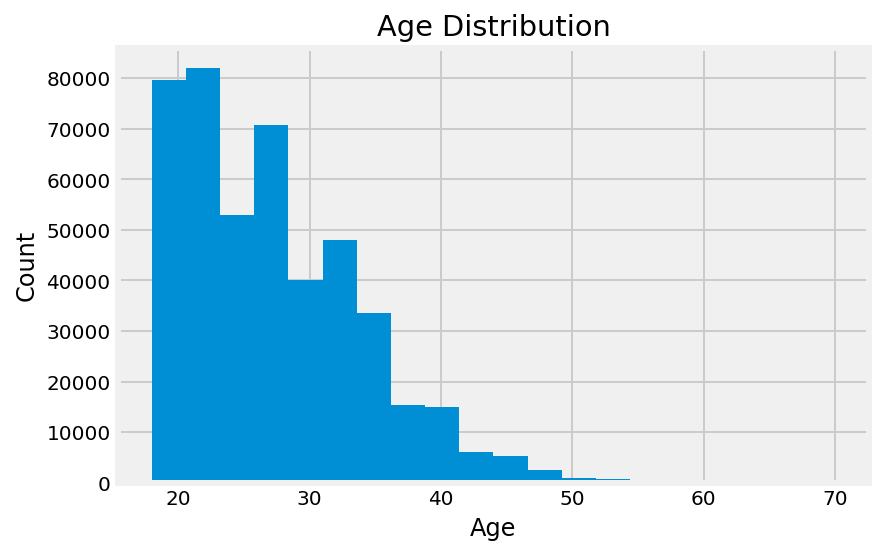

In [17]:
data.age.hist(bins=20)
plt.title('Age Distribution')
plt.ylabel('Count')
plt.xlabel('Age')
plt.show()

In [18]:
data.country.value_counts()

Mexico         128484
Colombia        54060
Spain           51782
Argentina       46733
Peru            33666
Venezuela       32054
Chile           19737
Ecuador         15895
Guatemala       15125
Bolivia         11124
Honduras         8568
El Salvador      8175
Paraguay         7347
Nicaragua        6723
Costa Rica       5309
Uruguay          4134
Panama           3951
Name: country, dtype: int64

In [19]:
data.test.value_counts()

0    237093
1    215774
Name: test, dtype: int64

In [20]:
data.conversion.value_counts()

0    430423
1     22444
Name: conversion, dtype: int64

In [21]:
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico


In [22]:
data.shape

(452867, 12)

The data looks relatively clean, I will move on to checking the test to see how spanish converts compared to other countries

# A/B Testing

In [23]:
spanish_group = data[data.test == 0][['country','conversion']].groupby('country').mean()

spanish_group.reset_index(inplace=True)
spanish_group.sort_values('conversion', ascending=False, inplace=True)

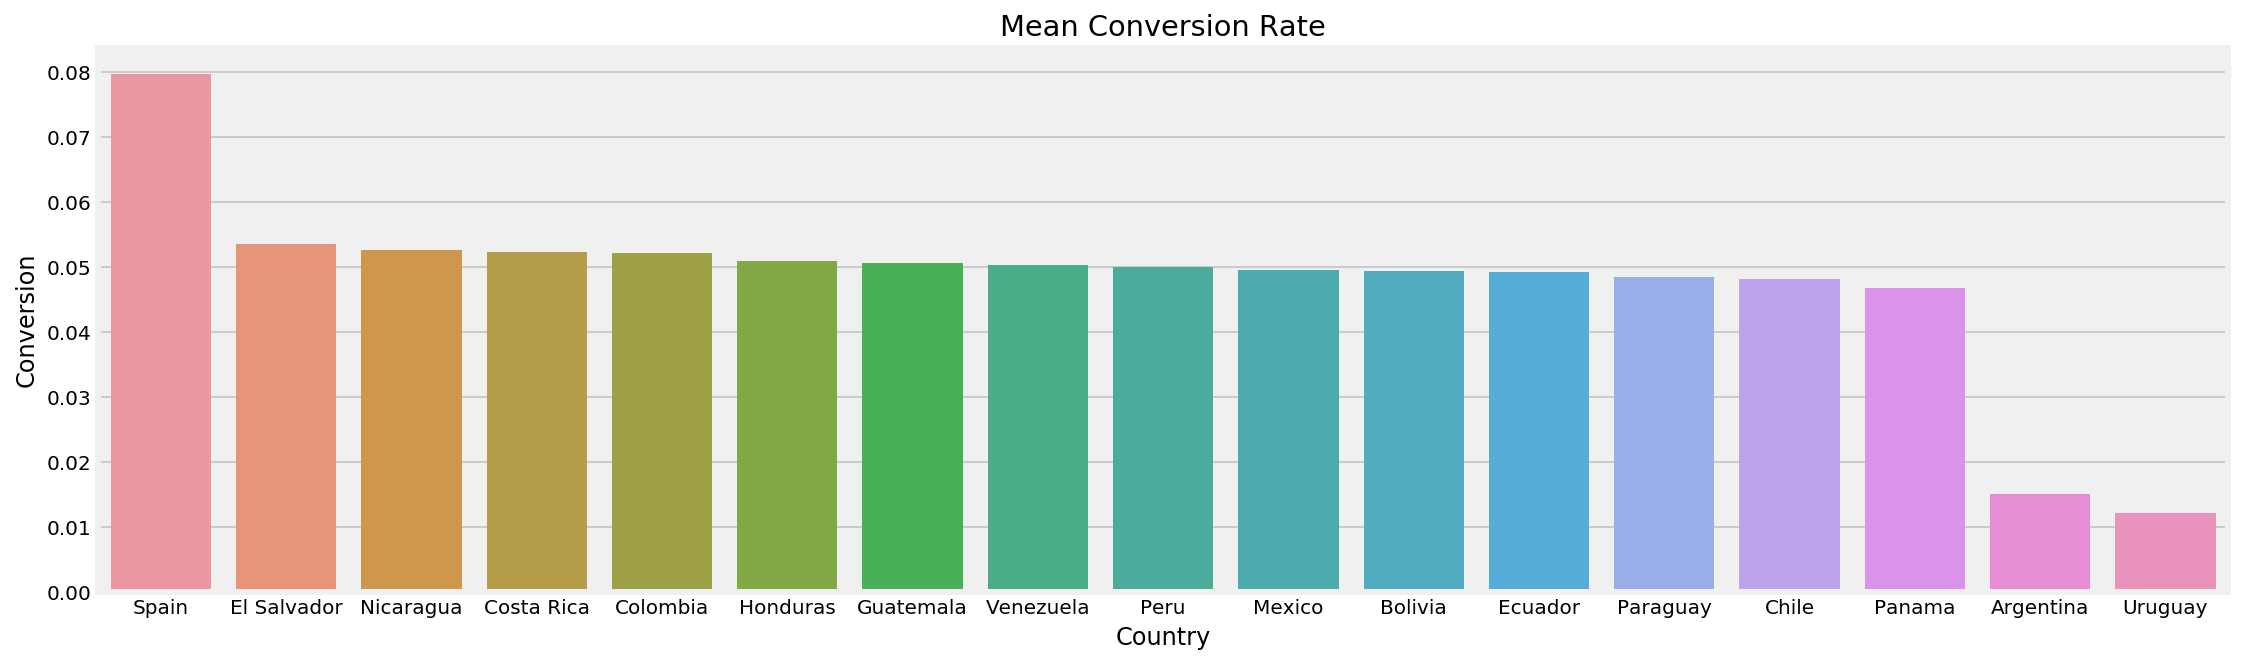

In [24]:
plt.figure(figsize=(17,5))
sns.barplot(x=spanish_group.country, y=spanish_group.conversion)
plt.title('Mean Conversion Rate')
plt.ylabel('Conversion')
plt.xlabel('Country')
plt.show()

Spain has the largest conversion mean which indicates that the spanish translation performs better at converting than other Latam translations.

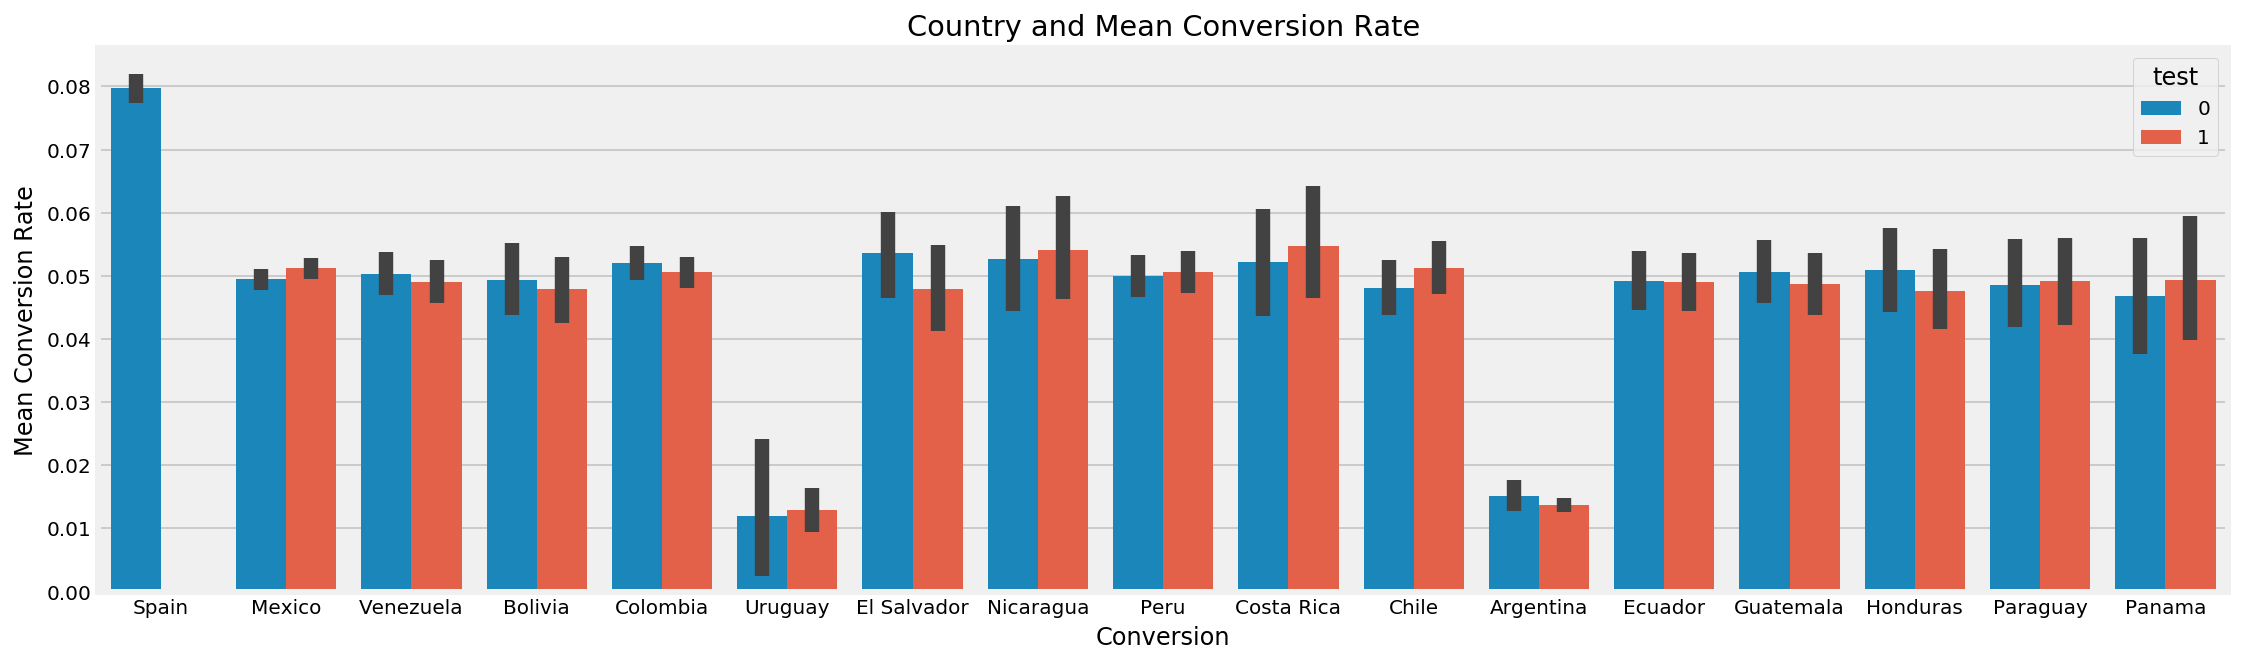

In [25]:
plt.figure(figsize=(17,5))
sns.barplot(x=data.country , y=data.conversion, hue=data.test)
plt.title('Country and Mean Conversion Rate')
plt.xlabel('Conversion')
plt.ylabel('Mean Conversion Rate')
plt.show()

In [26]:
# not including spain

test_data = data[data.country != 'Spain']
test_data.shape

(401085, 12)

In [27]:
test_val = test_data[test_data.test == 1]['conversion'].values
non_test_val = test_data[test_data.test == 0]['conversion'].values
print(test_val.mean(), '\t', non_test_val.mean())

0.043411161678422794 	 0.04829179055749524


we now have t-test values

In [28]:
ttest_ind(test_val, non_test_val, equal_var=False)

Ttest_indResult(statistic=-7.353895203080277, pvalue=1.9289178577799033e-13)

## Are Localized Translations Worse

In [29]:
test_data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico
5,540675,2015-12-03,Direct,Mobile,ES,NaN,Android_App,0,1,F,22,Venezuela
6,863394,2015-12-04,SEO,Mobile,Other,NaN,Android_App,0,0,M,35,Mexico


In [30]:
# I am going to look into the conversion across dates and what the mean conversion rate on each day is

In [31]:
test_data.date.value_counts()

2015-12-04    124894
2015-12-03     88110
2015-12-01     62835
2015-11-30     62826
2015-12-02     62420
Name: date, dtype: int64

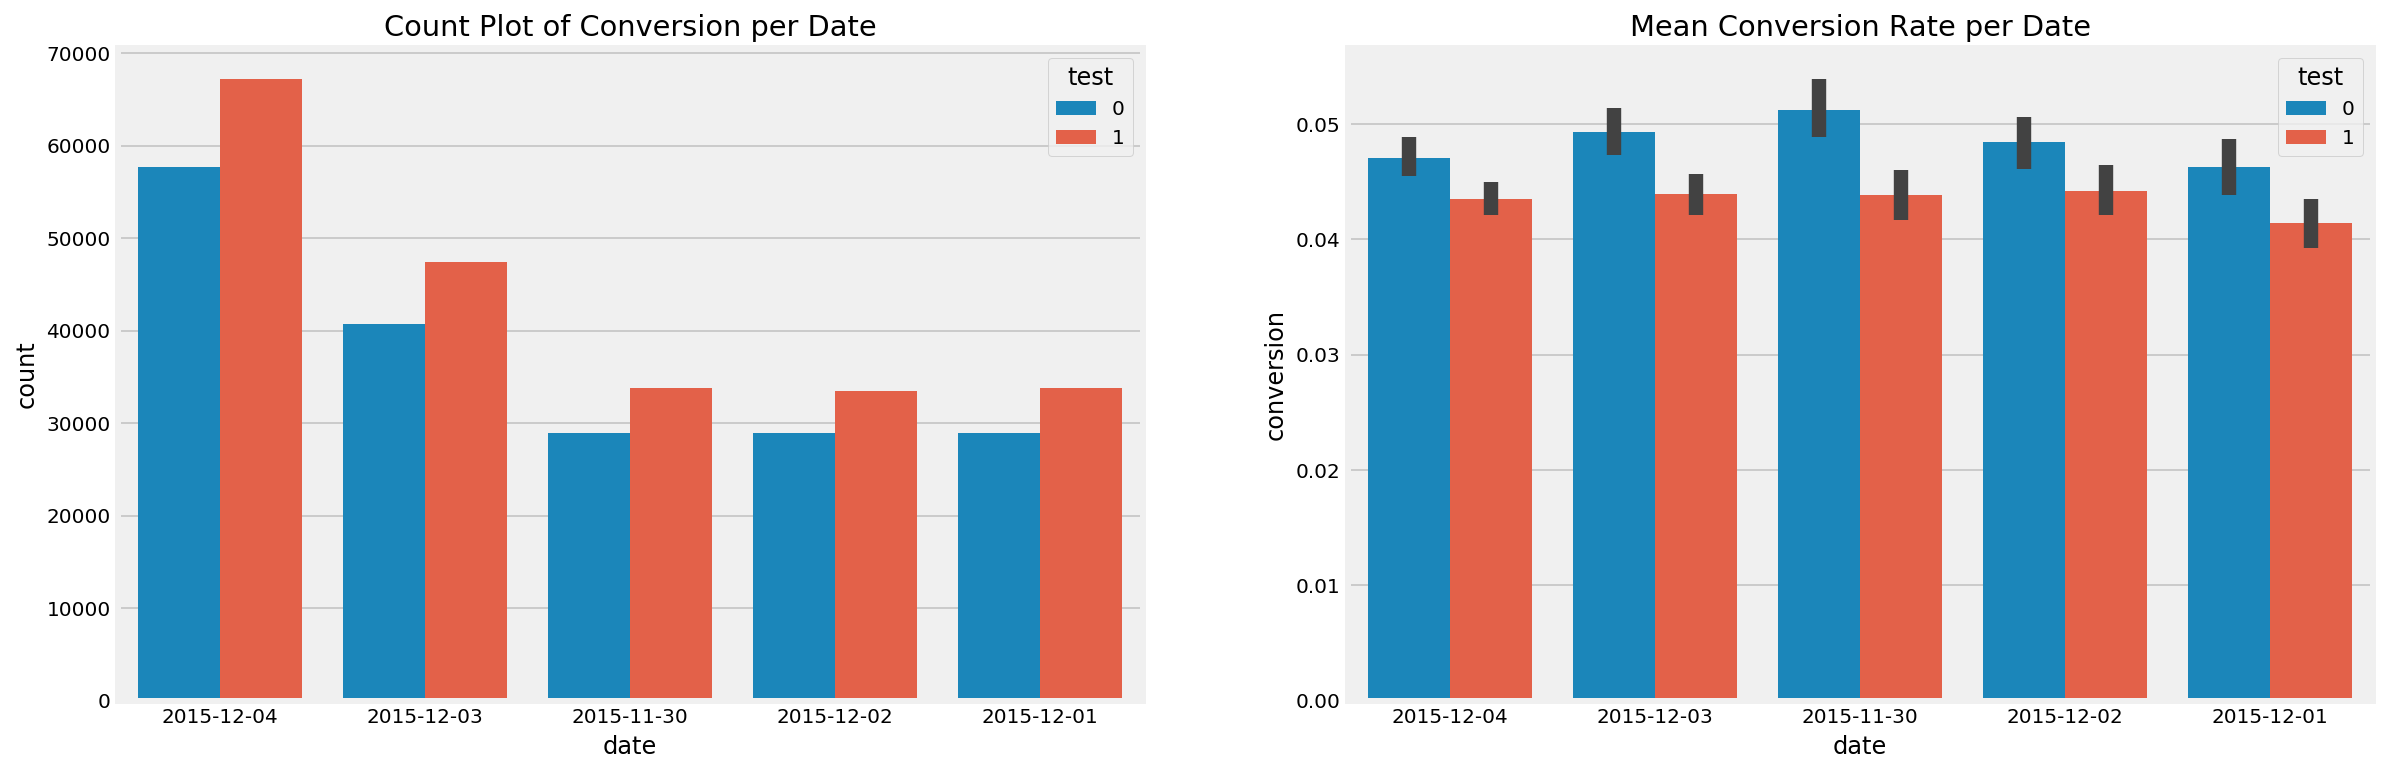

In [32]:
count_bar(test_data, 'date','conversion','test','Date')

In [33]:
# Look into different sources and their impact

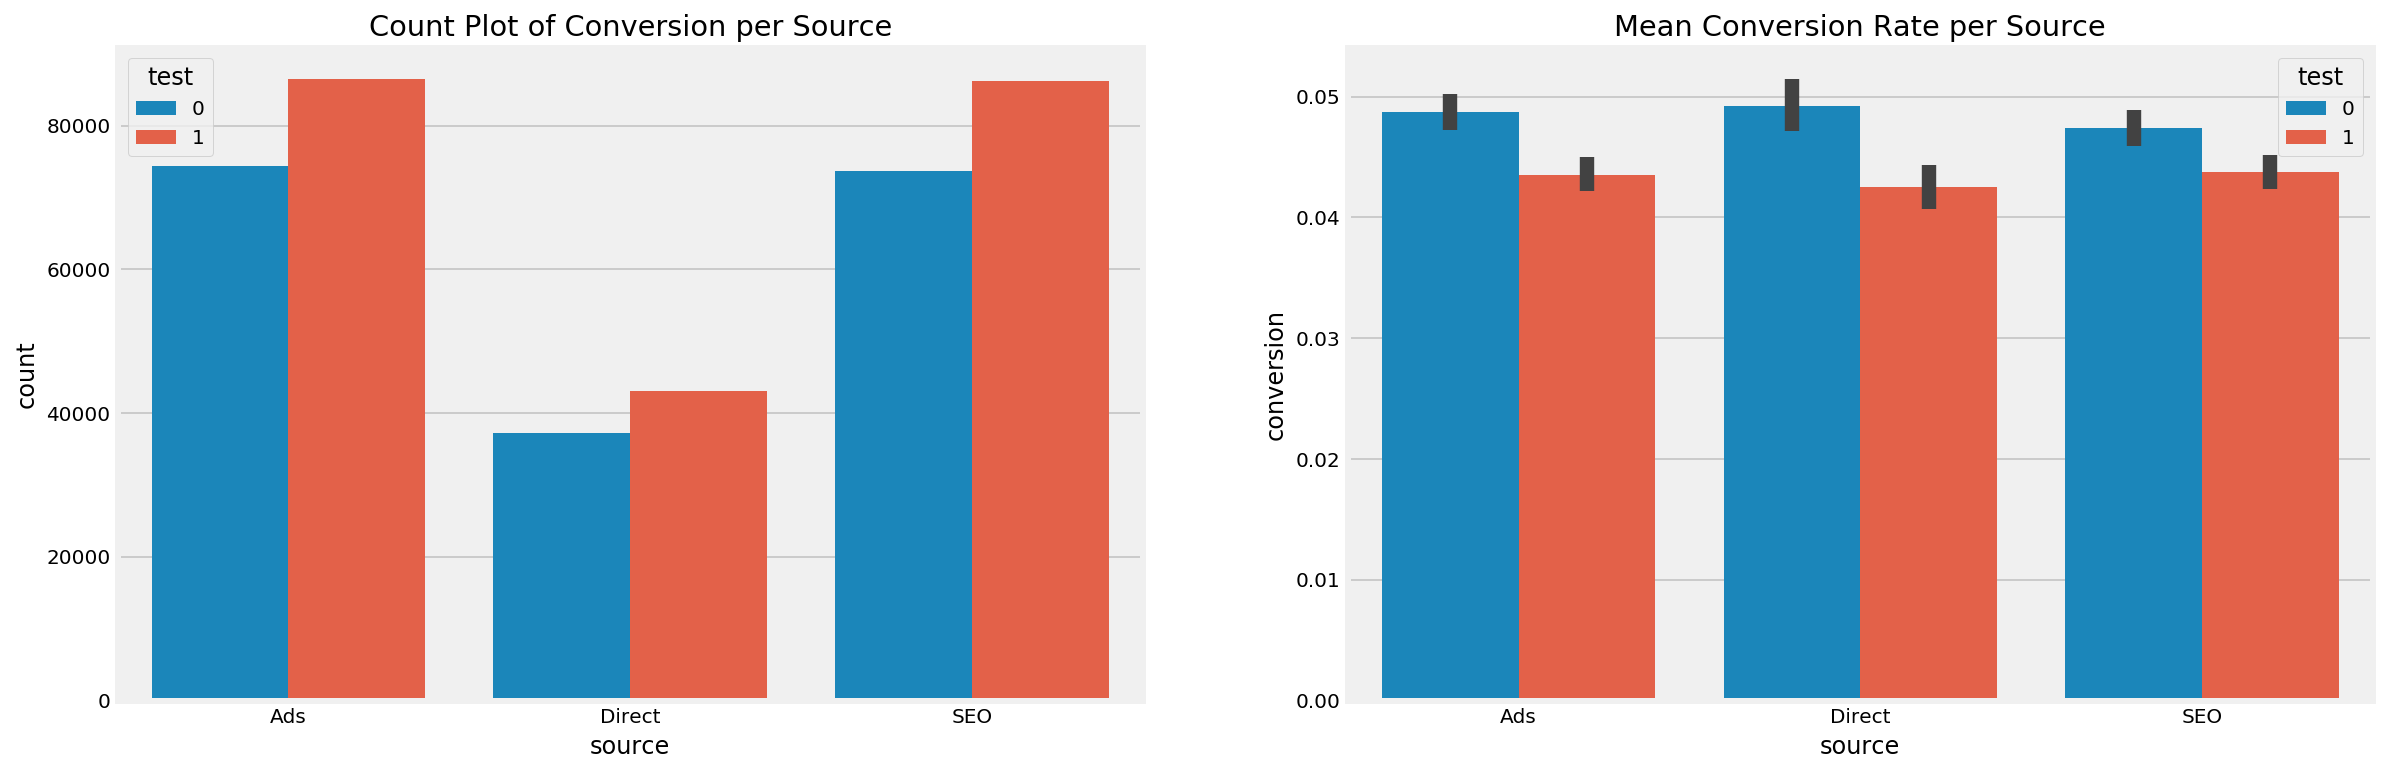

In [34]:
count_bar(test_data, 'source','conversion','test','Source')

In [35]:
# Look into different devices

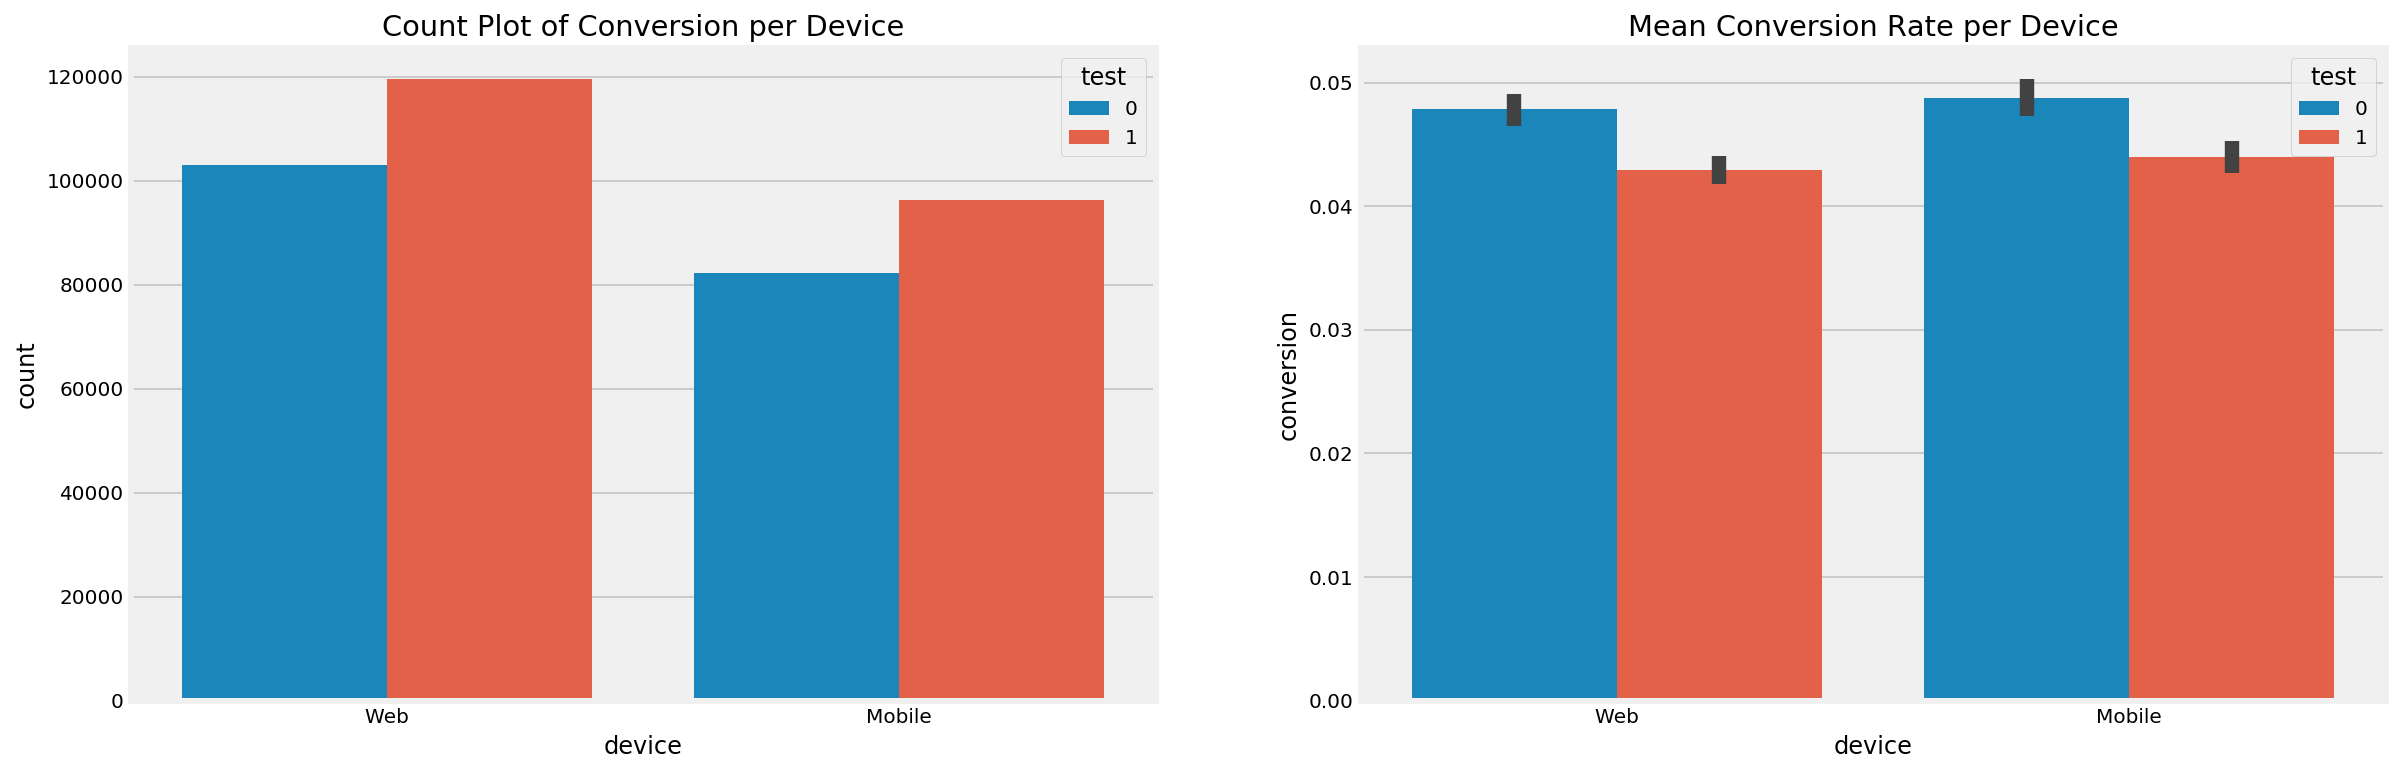

In [36]:
count_bar(test_data, 'device','conversion','test','Device')

In [37]:
# Look into different Language

In [38]:
test_data.columns

Index(['user_id', 'date', 'source', 'device', 'browser_language',
       'ads_channel', 'browser', 'conversion', 'test', 'sex', 'age',
       'country'],
      dtype='object')

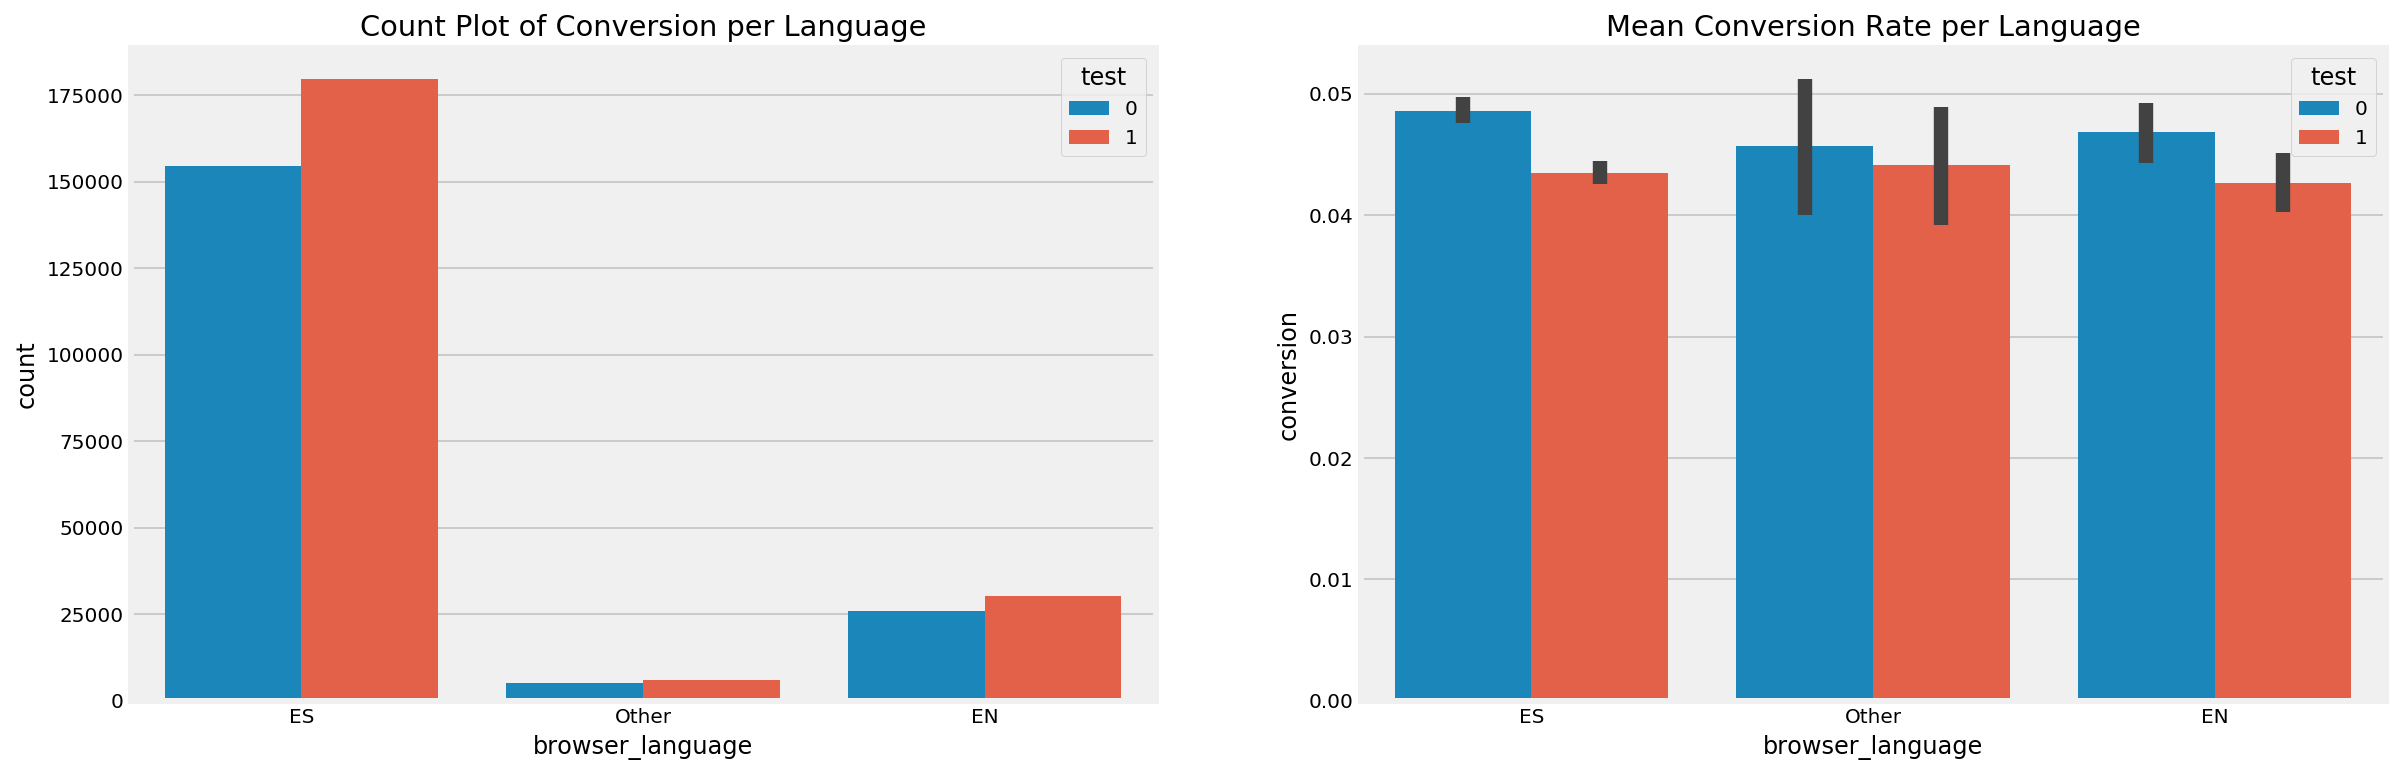

In [39]:
count_bar(test_data, 'browser_language','conversion','test','Language')

In [40]:
# Look into different Browser

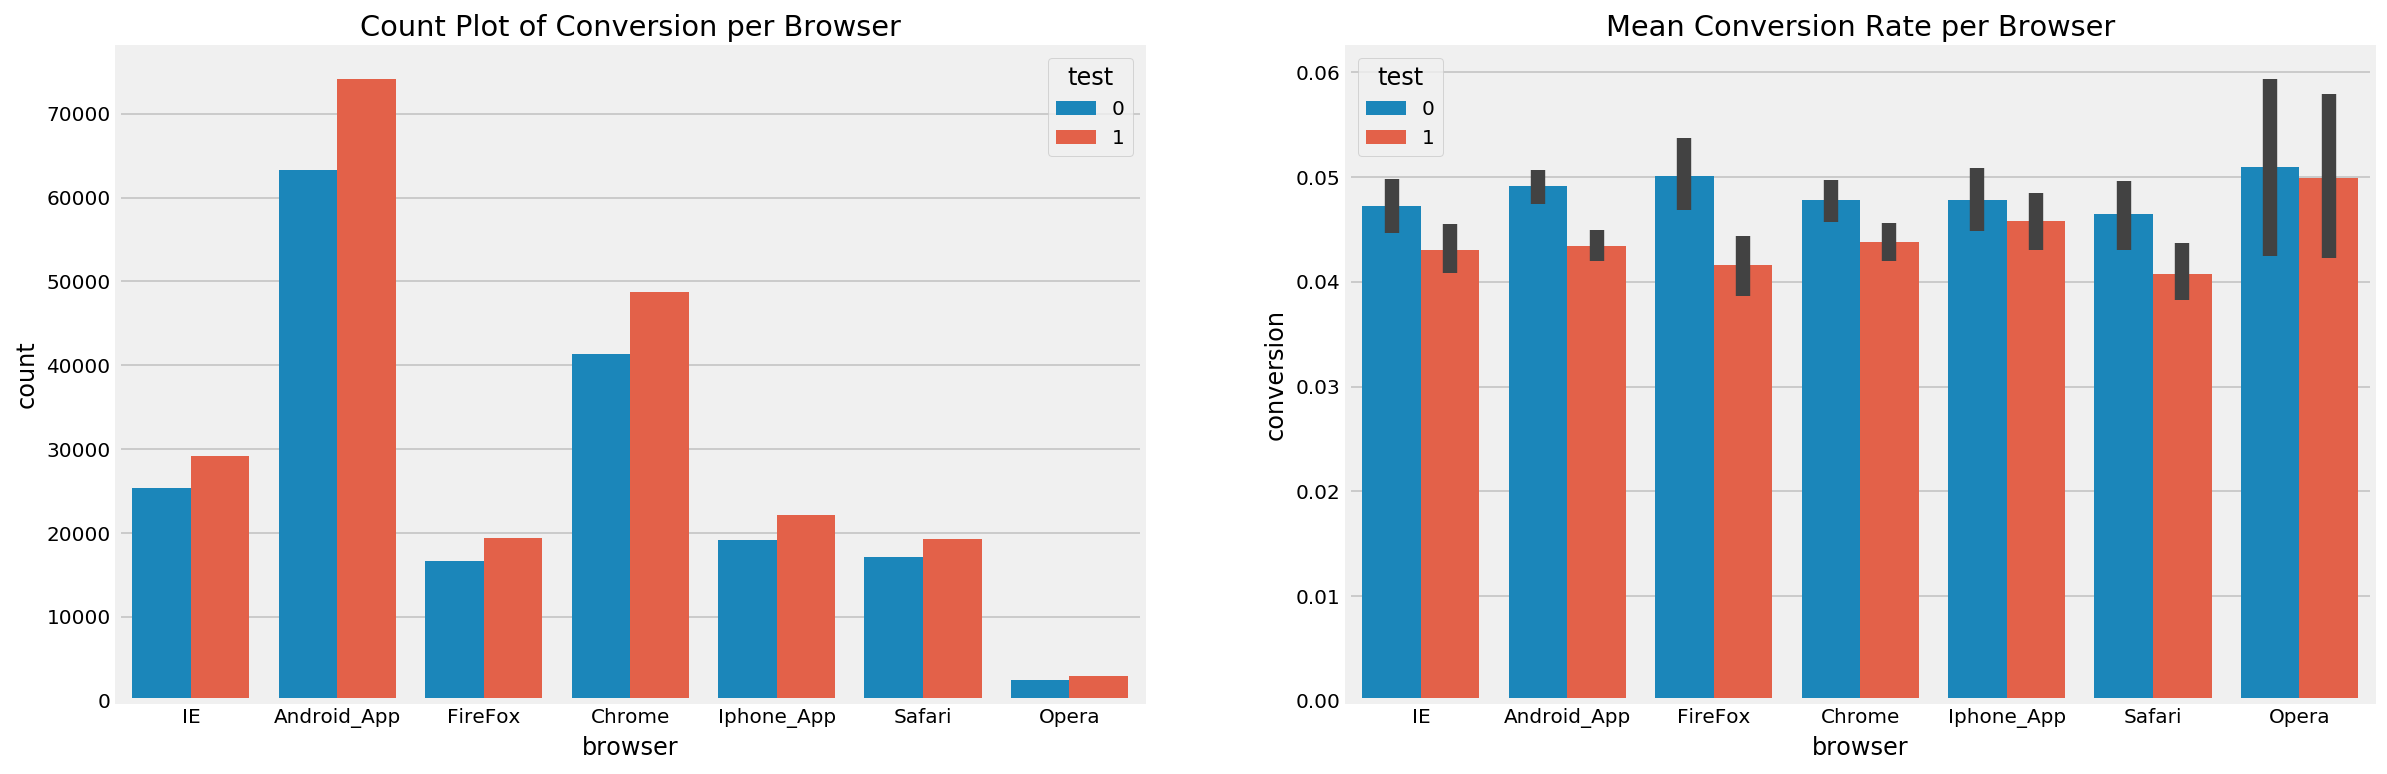

In [41]:
count_bar(test_data, 'browser','conversion','test','Browser')

In [42]:
# Look into different Ads Channel

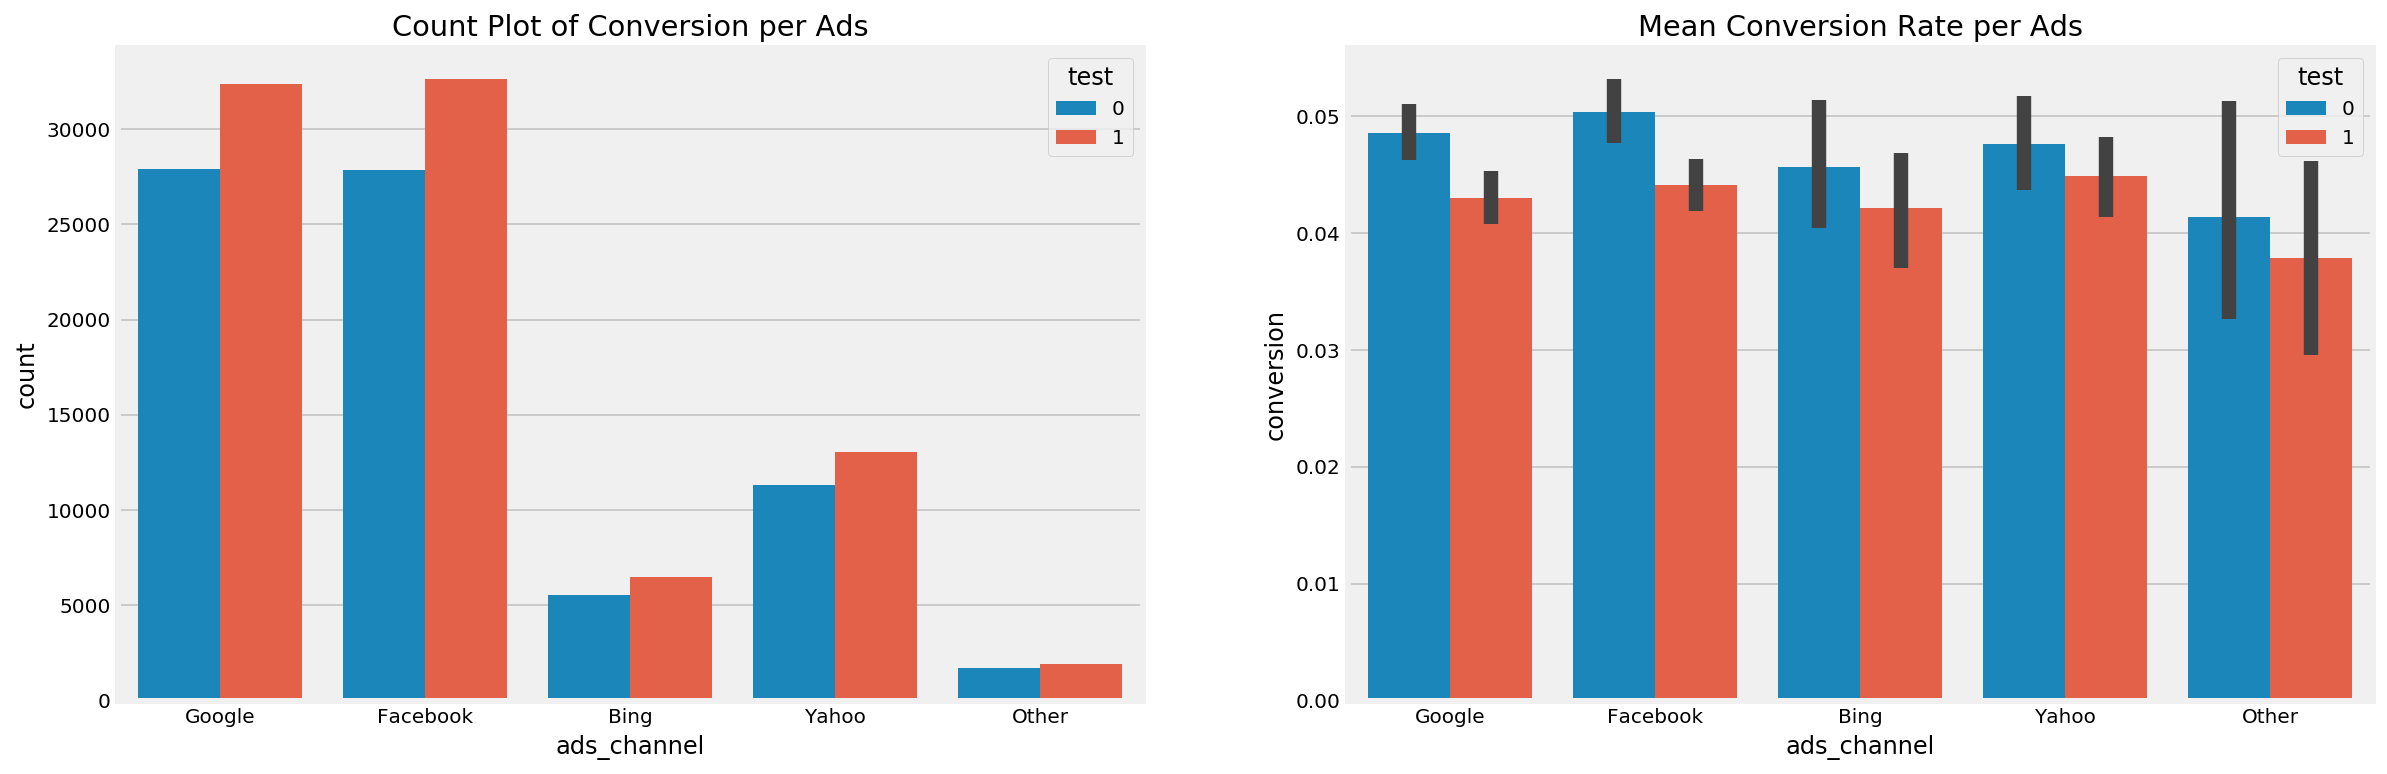

In [43]:
count_bar(test_data, 'ads_channel','conversion','test','Ads')

In [44]:
# Look into different Sex

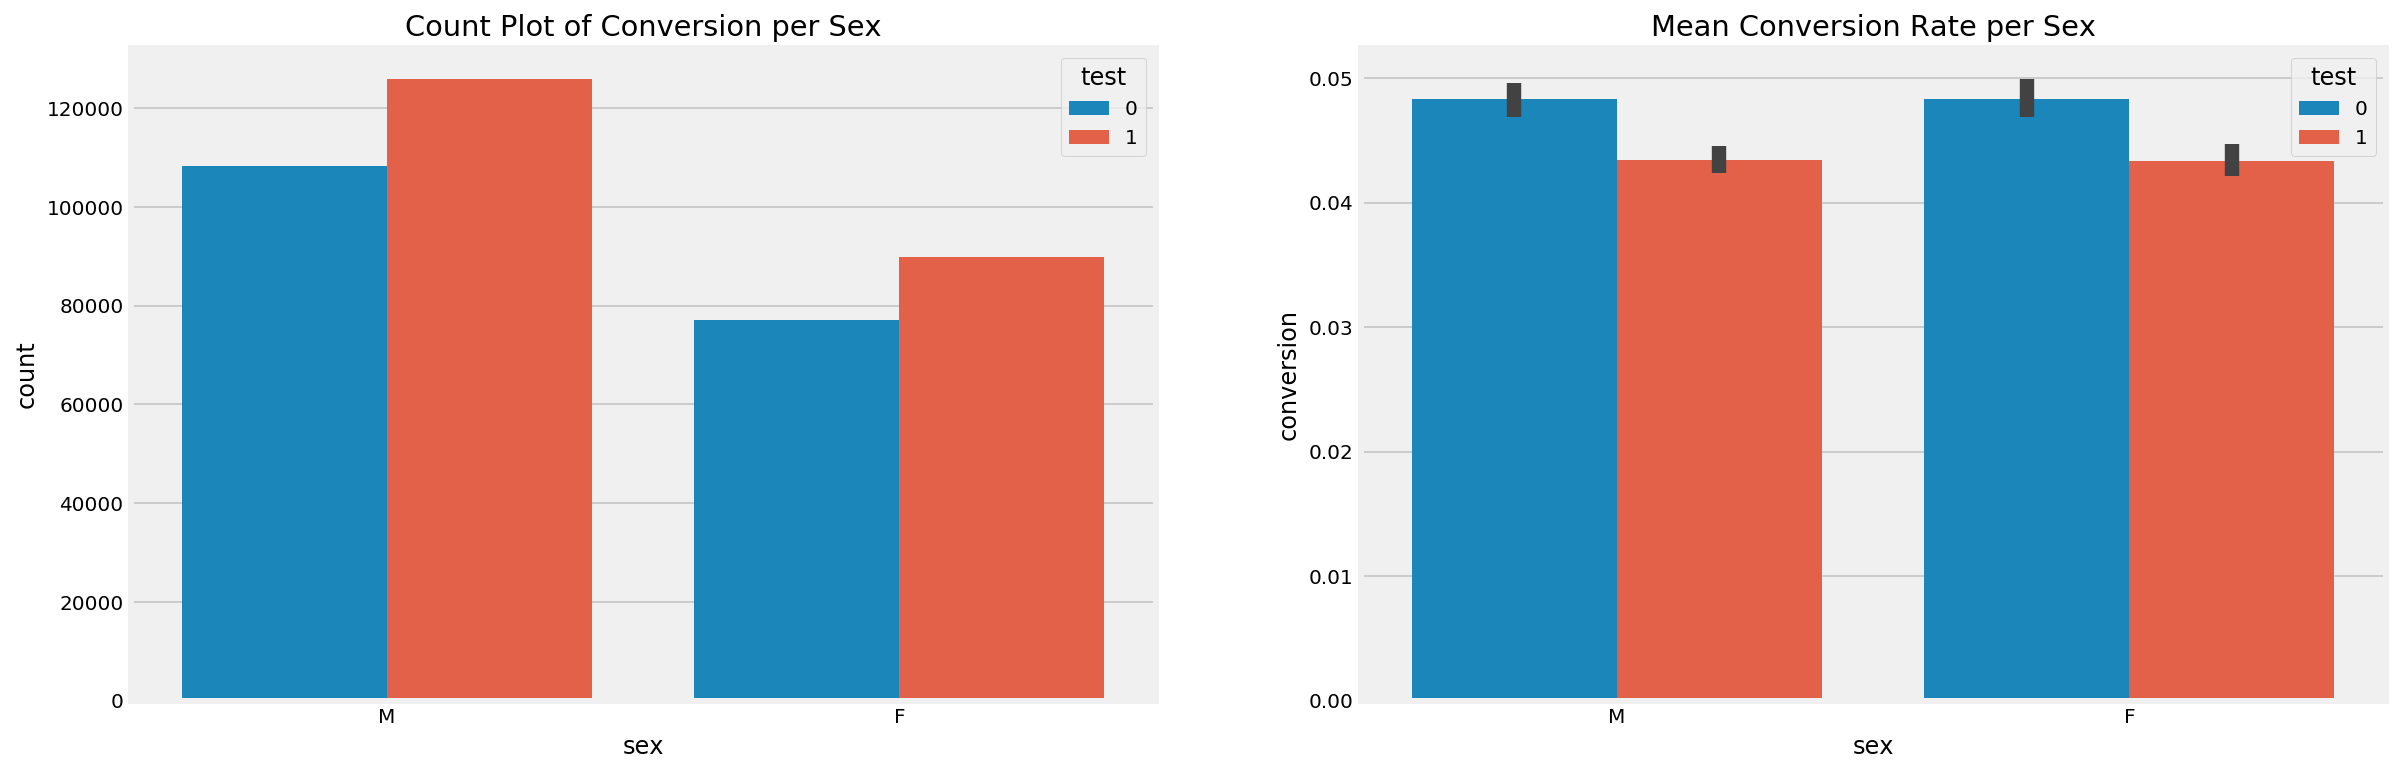

In [45]:
count_bar(test_data, 'sex','conversion','test','Sex')

In [46]:
# Look into different age

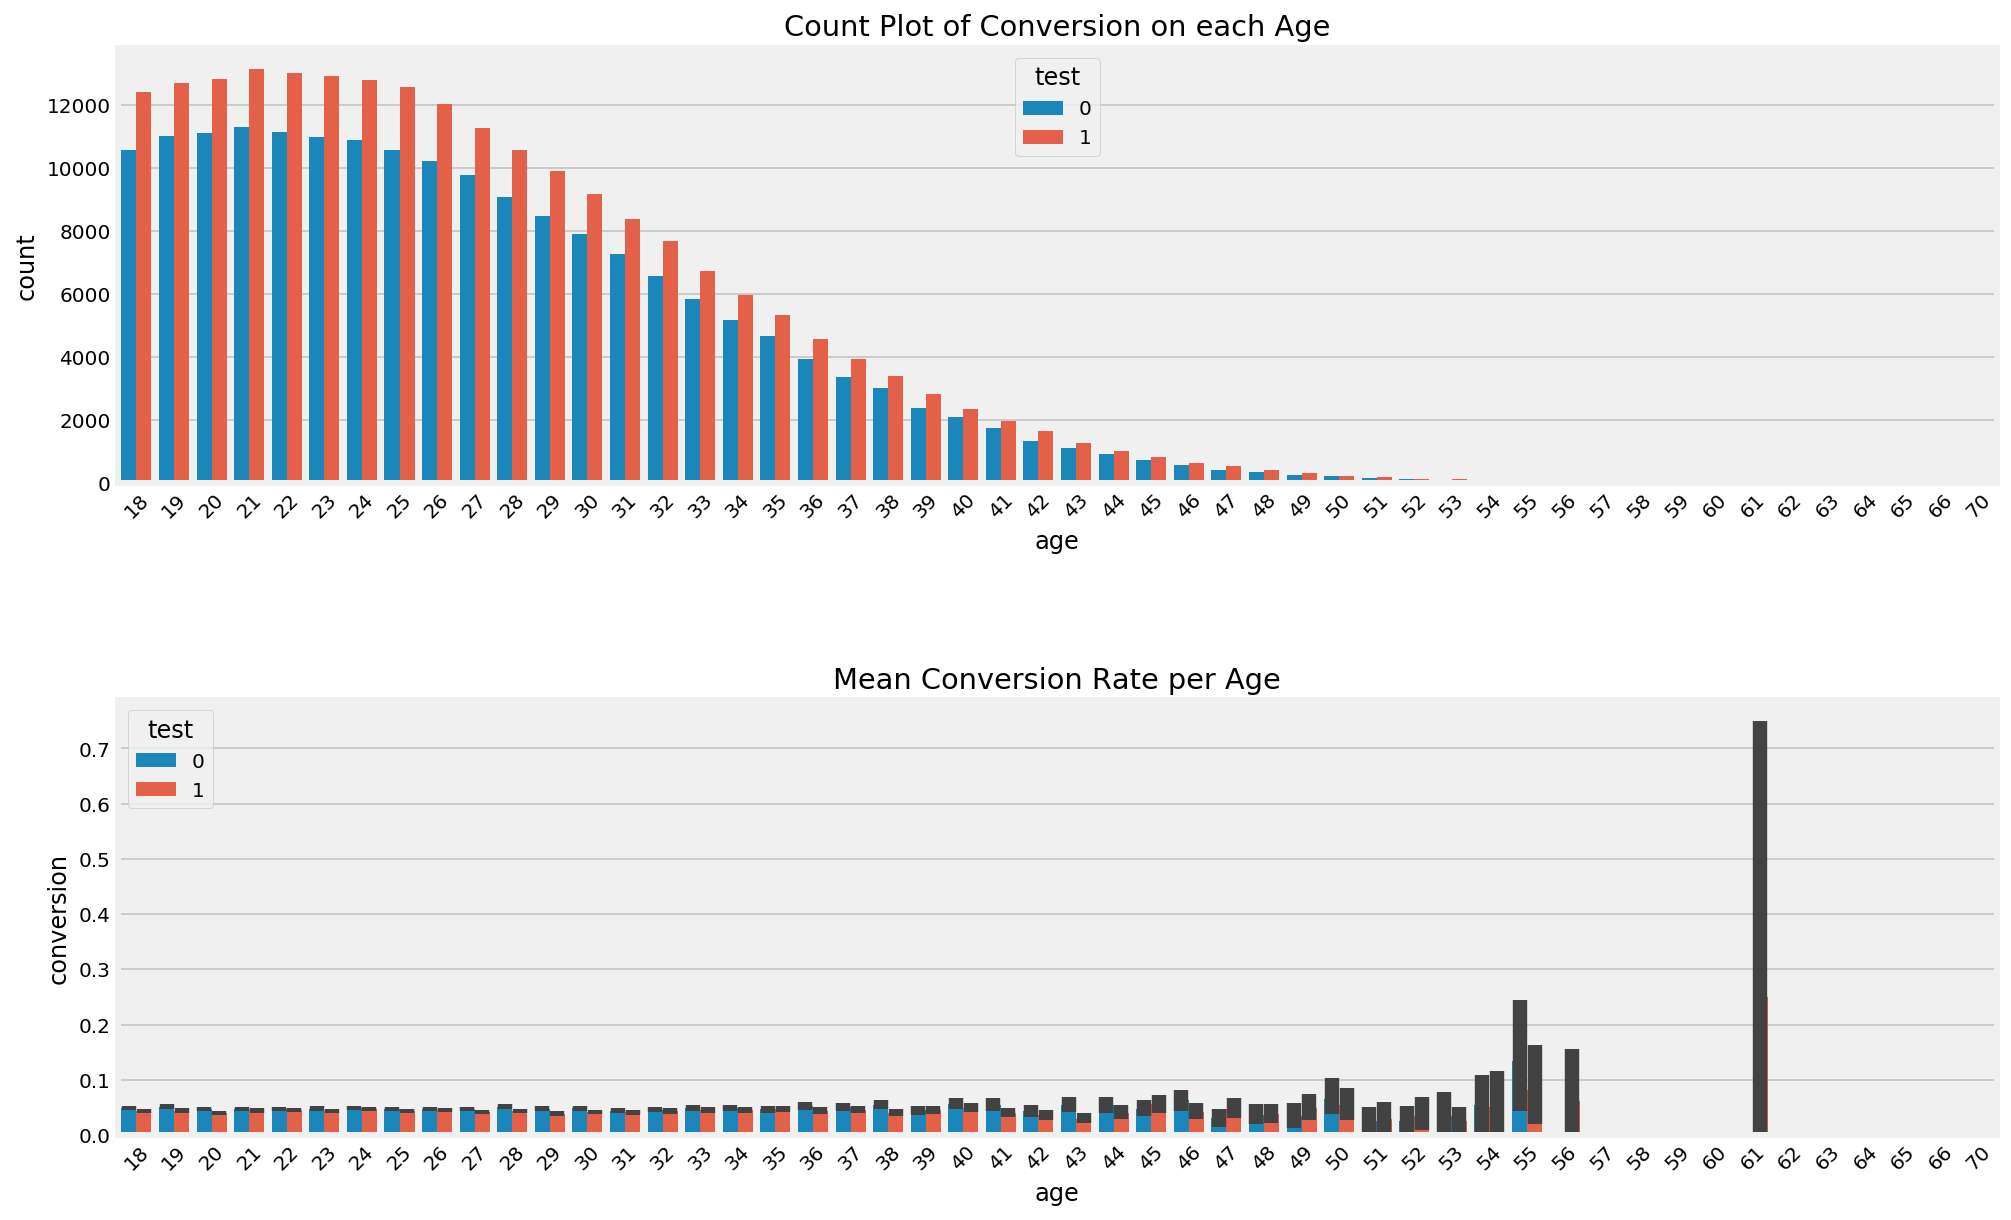

In [47]:
fig, ax = plt.subplots(nrows=2, figsize=(15,10))
plt.subplots_adjust(hspace=.5)
sns.countplot(x='age', hue='test',data=test_data , ax=ax[0])
ax[0].set_title('Count Plot of Conversion on each {}'.format('Age'))
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)
sns.barplot(x='age',y='conversion', hue='test',data=test_data , ax=ax[1])
ax[1].set_title('Mean Conversion Rate per {}'.format('Age'))
for tick in ax[1].get_xticklabels():
    tick.set_rotation(45)
plt.show()

In [48]:
# Look into different Country

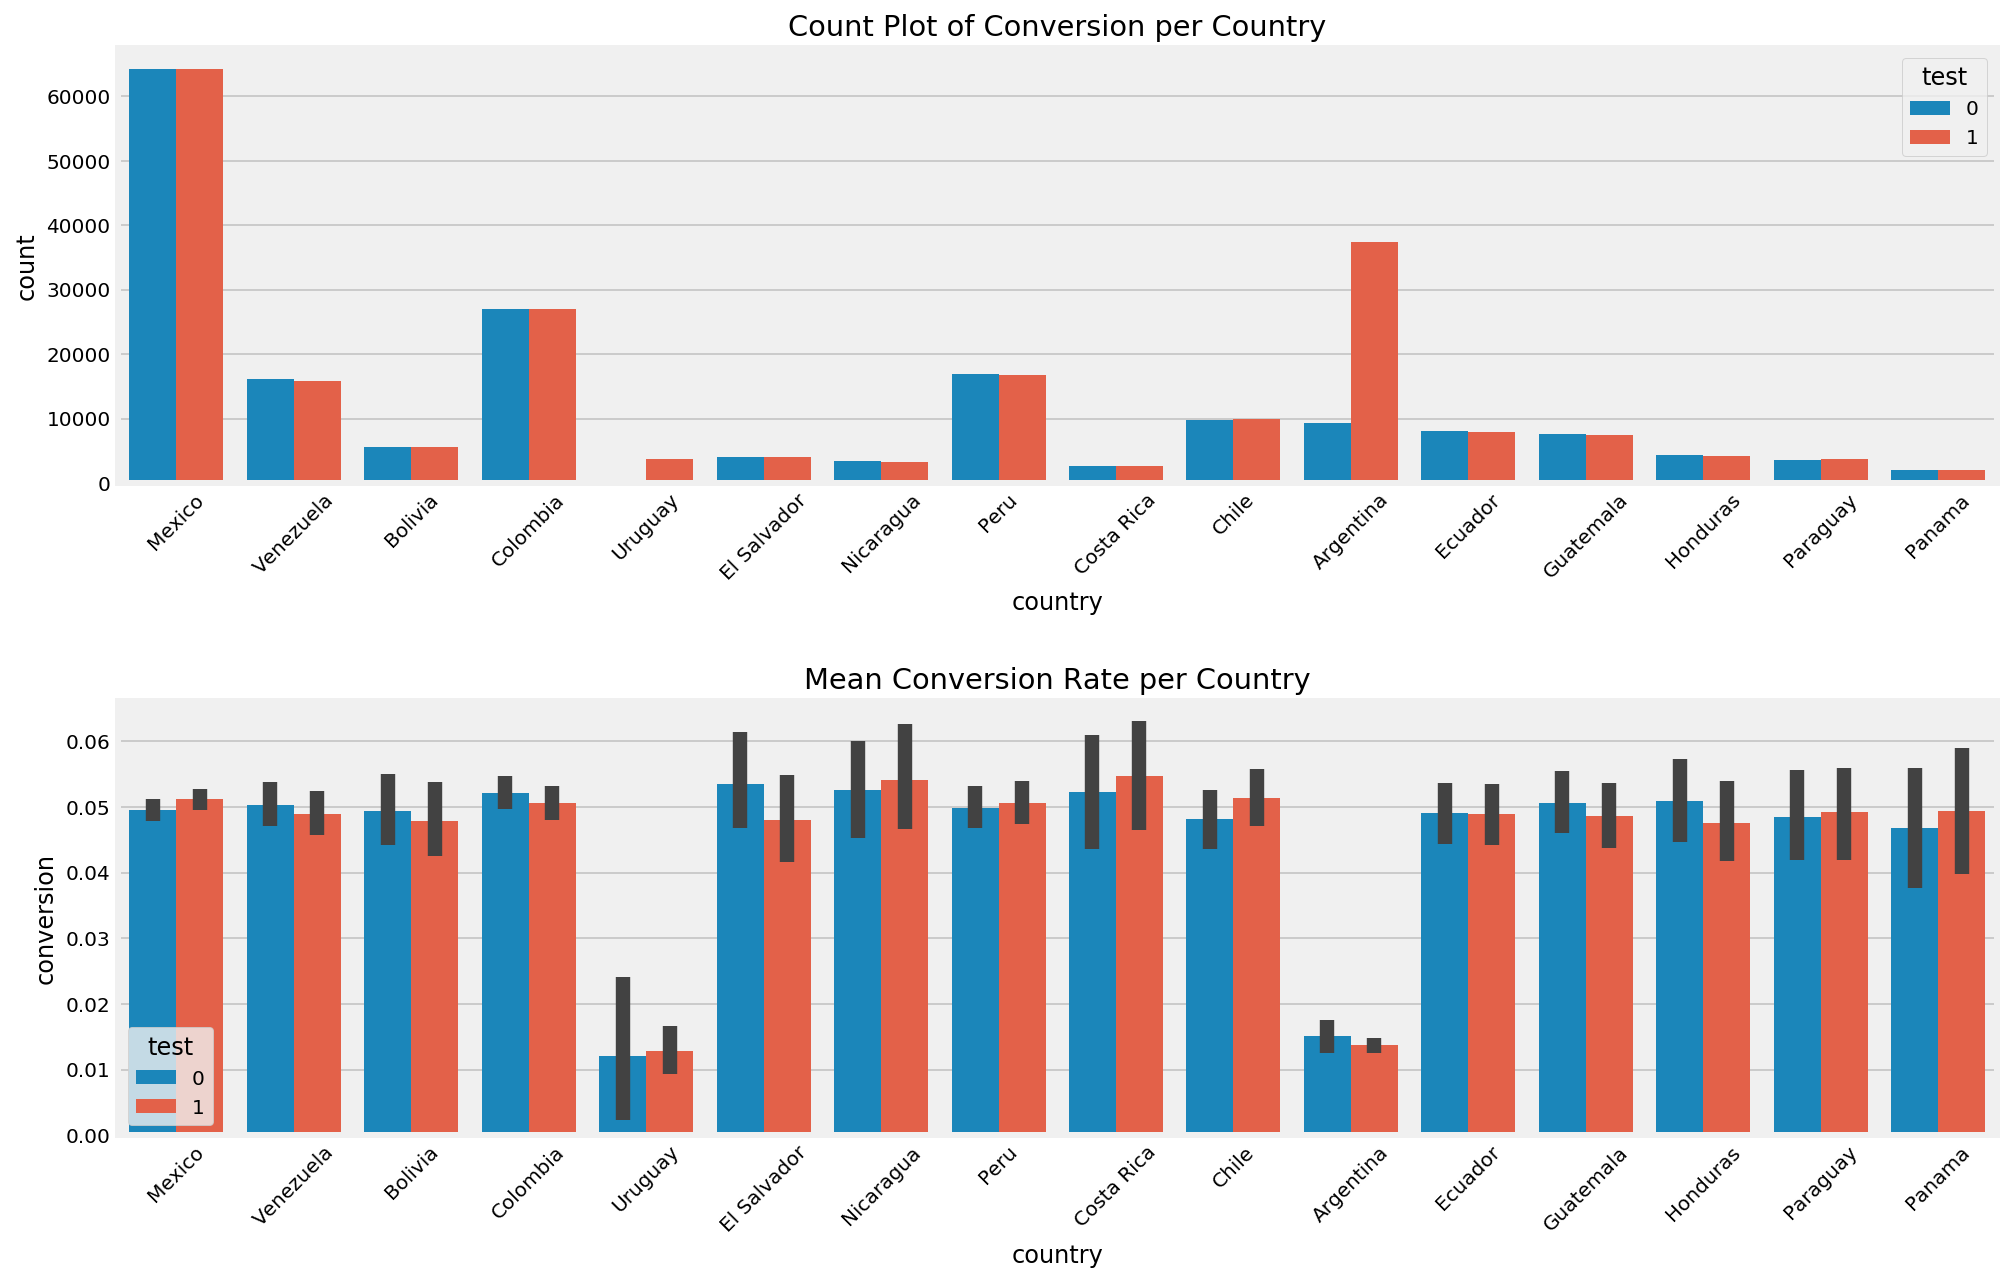

In [49]:
fig, ax = plt.subplots(nrows=2, figsize=(15,10))
plt.subplots_adjust(hspace=.5)
sns.countplot(x='country', hue='test',data=test_data , ax=ax[0])
ax[0].set_title('Count Plot of Conversion per {}'.format('Country'))
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)
sns.barplot(x='country',y='conversion', hue='test',data=test_data , ax=ax[1])
ax[1].set_title('Mean Conversion Rate per {}'.format('Country'))
for tick in ax[1].get_xticklabels():
    tick.set_rotation(45)
plt.show()

In [50]:
test_data.groupby(['country','test']).size()

country      test
Argentina    0        9356
             1       37377
Bolivia      0        5550
             1        5574
Chile        0        9853
             1        9884
Colombia     0       27088
             1       26972
Costa Rica   0        2660
             1        2649
Ecuador      0        8036
             1        7859
El Salvador  0        4108
             1        4067
Guatemala    0        7622
             1        7503
Honduras     0        4361
             1        4207
Mexico       0       64209
             1       64275
Nicaragua    0        3419
             1        3304
Panama       0        1966
             1        1985
Paraguay     0        3650
             1        3697
Peru         0       16869
             1       16797
Uruguay      0         415
             1        3719
Venezuela    0       16149
             1       15905
dtype: int64

In [51]:
## The test group performs worse at converting the user 

## Some countries to keep an eye on are Uruguay, argentina where the count is unevenly distrubuted
## 

In [52]:
for country in [a for a in test_data.country.unique()]:
    print(country,'\n',test_data[test_data.country == country].conversion.value_counts(normalize=True),'\n')

Mexico 
 0    0.949659
1    0.050341
Name: conversion, dtype: float64 

Venezuela 
 0    0.950334
1    0.049666
Name: conversion, dtype: float64 

Bolivia 
 0    0.951366
1    0.048634
Name: conversion, dtype: float64 

Colombia 
 0    0.948668
1    0.051332
Name: conversion, dtype: float64 

Uruguay 
 0    0.987179
1    0.012821
Name: conversion, dtype: float64 

El Salvador 
 0    0.949235
1    0.050765
Name: conversion, dtype: float64 

Nicaragua 
 0    0.946601
1    0.053399
Name: conversion, dtype: float64 

Peru 
 0    0.949742
1    0.050258
Name: conversion, dtype: float64 

Costa Rica 
 0    0.946506
1    0.053494
Name: conversion, dtype: float64 

Chile 
 0    0.950296
1    0.049704
Name: conversion, dtype: float64 

Argentina 
 0    0.986006
1    0.013994
Name: conversion, dtype: float64 

Ecuador 
 0    0.950928
1    0.049072
Name: conversion, dtype: float64 

Guatemala 
 0    0.950347
1    0.049653
Name: conversion, dtype: float64 

Honduras 
 0    0.950747
1    0.049253
Na

In [53]:
for country in [a for a in test_data.country.unique()]:
    test_val = test_data[(test_data.country == country) & (test_data.test == 1)]['conversion'].values
    cont_val = test_data[(test_data.country == country) & (test_data.test == 0)]['conversion'].values
    
    test_mean = test_val.mean()
    cont_mean = cont_val.mean()
    
    p_val = ttest_ind(test_val, cont_val, equal_var=False).pvalue
    
    print('{0:15s} {1:15.5f} {2:15.5f} {3:10f}'.format(country, test_mean, cont_mean, p_val))
    

Mexico                  0.05119         0.04949   0.165544
Venezuela               0.04898         0.05034   0.573702
Bolivia                 0.04790         0.04937   0.718885
Colombia                0.05057         0.05209   0.423719
Uruguay                 0.01291         0.01205   0.879764
El Salvador             0.04795         0.05355   0.248127
Nicaragua               0.05418         0.05265   0.780400
Peru                    0.05060         0.04991   0.771953
Costa Rica              0.05474         0.05226   0.687876
Chile                   0.05130         0.04811   0.302848
Argentina               0.01373         0.01507   0.335147
Ecuador                 0.04899         0.04915   0.961512
Guatemala               0.04865         0.05064   0.572107
Honduras                0.04754         0.05091   0.471463
Paraguay                0.04923         0.04849   0.883697
Panama                  0.04937         0.04680   0.705327


The p-values for each country for are not significant enough to draw any conclusions.

Both Uruguay and Argentina should be looked at more carefully since there is a large imbalance in the data, about 80% were put in the test group showing some sort of selection bias.

The hypothesis that localisation caused a poor conversion rate cannot be proved, to further look into this the data should be collected over a longer period of time - maybe a month long period. Doing this would allow any patterns to be captured as it is apparent that more purchases were made on the friday, extending this to a month would allow pay days to be picked up too which could see a spike in purchases.

I will now use PYMC3 to carry out further testing to back up these results.

# Pre processing for PYMC 3

In [54]:
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico


To drop : user_id

To predict : conversion

pymc3 variable : test

In [55]:
data.drop(columns=['user_id'], inplace=True)

### Date

In [56]:
data.date.value_counts()
# 30/11 - Monday
# 1/12 - Tuesday
# 2/12 - Wednesday
# 3/12 - Thursday
# 4/12 - Friday

# I will swap out the date with the day as its more interpretable

2015-12-04    141024
2015-12-03     99399
2015-11-30     70948
2015-12-01     70915
2015-12-02     70581
Name: date, dtype: int64

In [57]:
def date_for_day(date):
    """
    Changes the following date to their respective day:
    
    30/11 - Monday
    1/12 - Tuesday
    2/12 - Wednesday
    3/12 - Thursday
    4/12 - Friday
    """
    if int(date[-2:]) == 30:
        return 'Mon'
    elif int(date[-2:]) == 1:
        return 'Tue'
    elif int(date[-2:]) == 2:
        return 'Wed'
    elif int(date[-2:]) == 3:
        return 'Thur'
    else:
        return 'Fri'

In [58]:
data.date = data.date.apply(date_for_day)

### Ads Channel Nans

In [59]:
data.ads_channel.value_counts(dropna=False)
# Over half the data is a null value, change it to a NONE and infer that an ad channel wasnt used

NaN         271174
Facebook     68358
Google       68113
Yahoo        27409
Bing         13670
Other         4143
Name: ads_channel, dtype: int64

In [60]:
data.ads_channel.fillna('None', inplace=True)

## PYMC 3 on Mexico

In [61]:
mexico = data[data.country == 'Mexico']

In [62]:
cont_val = mexico[mexico.test == 0].conversion.values
test_val = mexico[mexico.test == 1].conversion.values

In [63]:

print(test_val.mean(), '\t', cont_val.mean(), '\nThe difference in mean is ', test_val.mean() - \
      cont_val.mean())



0.05118630882924932 	 0.04949461913438926 
The difference in mean is  0.0016916896948600615


In [64]:
tt = ttest_ind(test_val, cont_val, equal_var=False)

In [65]:
print('t-stats:\t', tt.statistic,
      '\np-value:\t', tt.pvalue)

t-stats:	 1.3866735952325449 
p-value:	 0.16554372211039645


In [66]:
mexico.test.value_counts(normalize=True)

1    0.500257
0    0.499743
Name: test, dtype: float64

In [67]:
mexico.test.value_counts()

1    64275
0    64209
Name: test, dtype: int64

In [68]:
# Let's say we also want to take a Baysian approach using MCMC to make doubly sure
# (in reality the sizes are large enough for this example that classical/frequentist is fine)

# Observed values
n = len(test_val) + len(cont_val)
obs_test = (test_val == 1).sum()
obs_cont = (cont_val == 1).sum()

with pm.Model() as model: # Context management
    # Define priors -- flat distributions for each
    prior_test = pm.Uniform('prior_test', 0, 1)
    prior_cont = pm.Uniform('prior_cont', 0, 1)

    # Define likelihood -- binomial likelihoods, feeding in the priors and observed data for each
    like_test = pm.Binomial('like_test', n=n, p=prior_test, observed=obs_test) 
    like_cont = pm.Binomial('like_cont', n=n, p=prior_cont, observed=obs_cont)
    
    # Define metrics -- these are our differences between the two distibutions
    pm.Deterministic('difference', prior_test - prior_cont)
    pm.Deterministic('relation', (prior_test/prior_cont)-1)
    
    # Inference
    trace = pm.sample(draws=50000, step=pm.Metropolis(), start=pm.find_MAP(), progressbar=True)

logp = -9.8938, ||grad|| = 1.2272e-07: 100%|██████████| 12/12 [00:00<00:00, 999.08it/s]   
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [prior_cont]
>Metropolis: [prior_test]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:18<00:00, 5358.28draws/s]
The number of effective samples is smaller than 10% for some parameters.


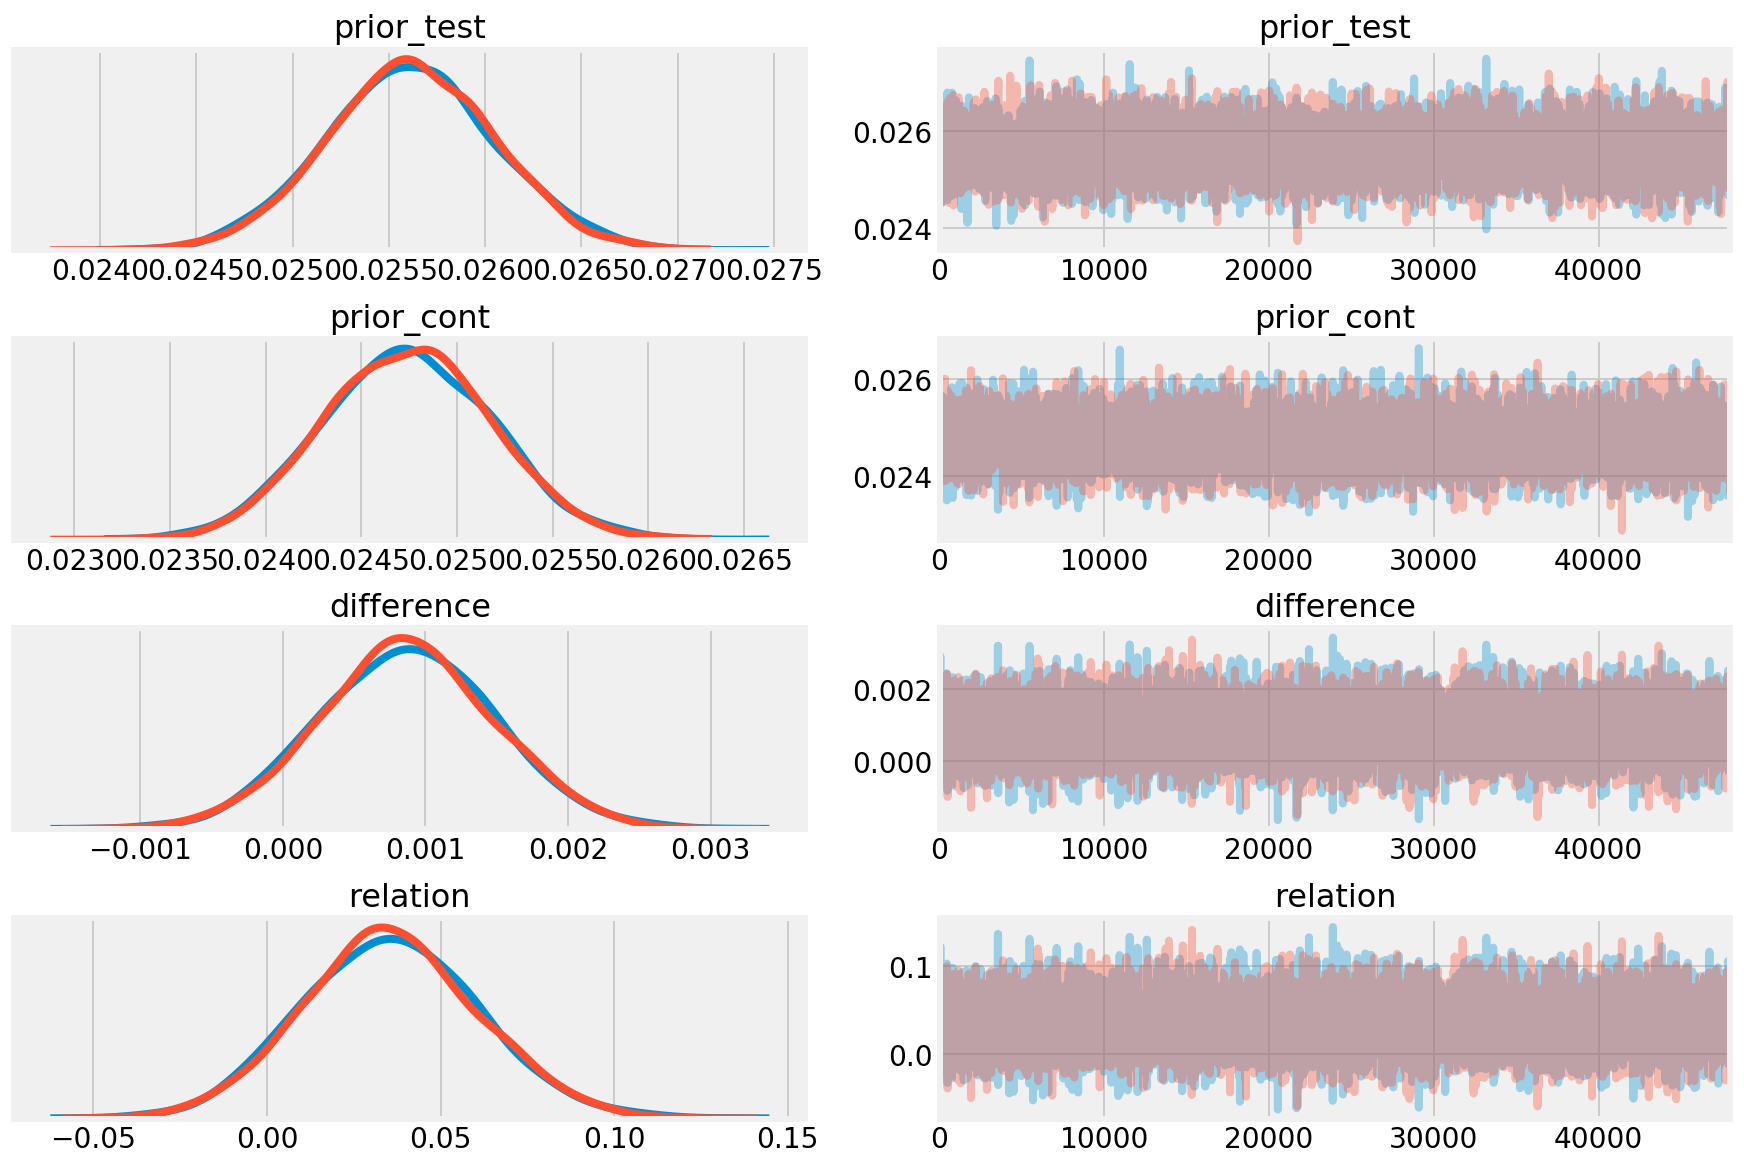

In [69]:
pm.traceplot(trace[2000:]);

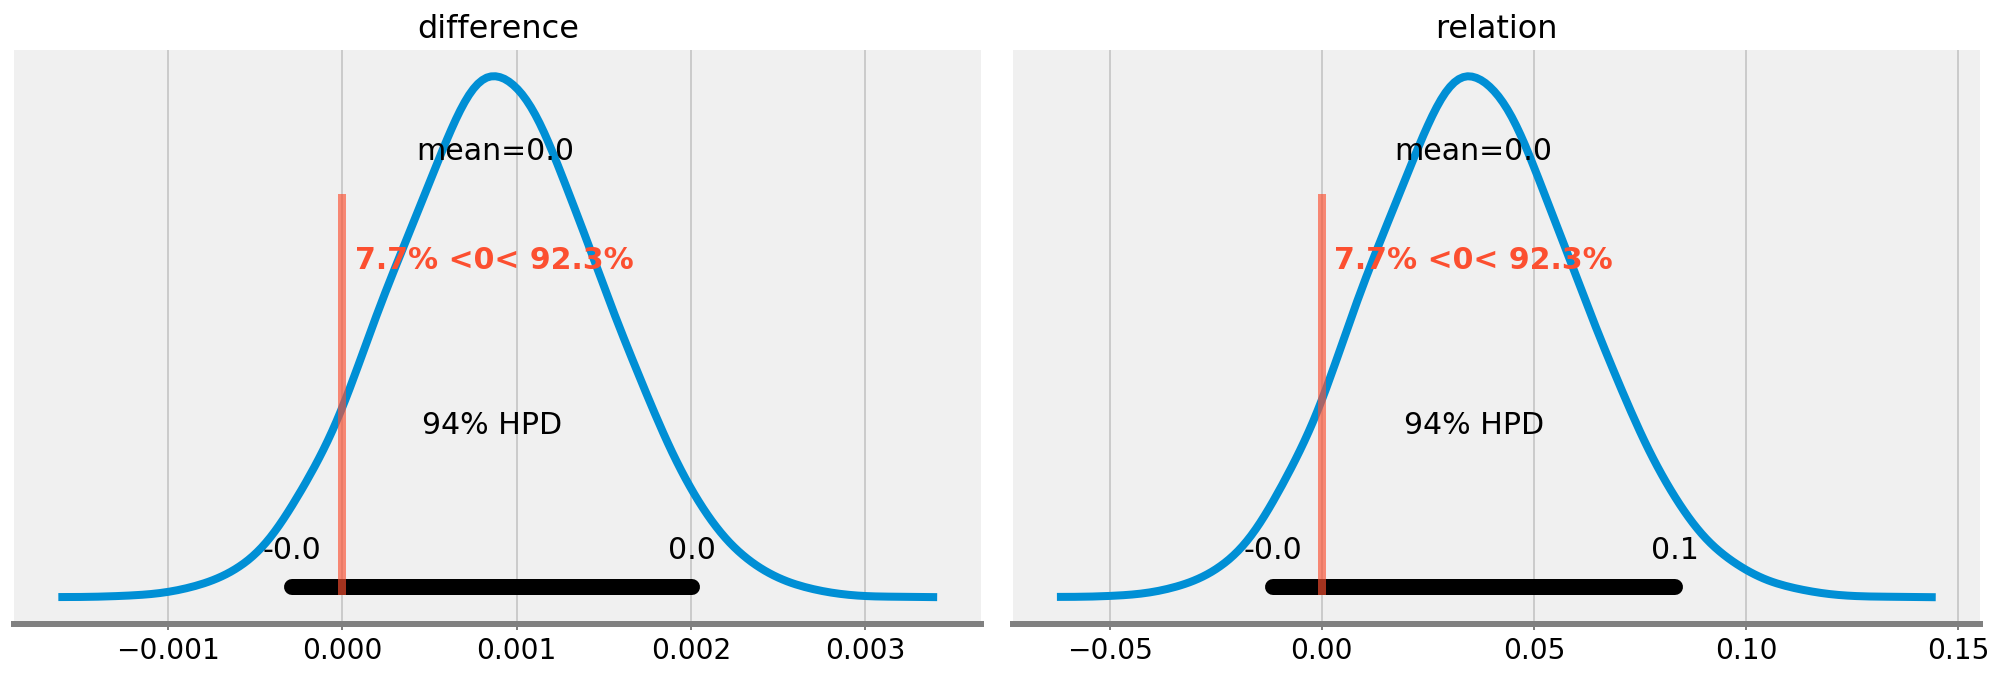

In [70]:
pm.plot_posterior(trace[2000:], varnames=['difference', 'relation'], 
                      ref_val=0, color='#87ceeb');

In [71]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
prior_test,0.025617,0.000435,0.000005,0.024731,0.026436,7998.858589,0.999997
prior_cont,0.024742,0.000439,0.000005,0.023875,0.025582,8392.799381,0.999991
difference,0.000875,0.000615,0.000007,-0.000370,0.002031,8473.038833,0.999991
relation,0.035703,0.025329,0.000276,-0.014033,0.084548,8477.540814,0.999990
